*This is inspired from works of many folks I have had the pleasure to meet during the previous competitons. A detail insight into TFRecord file format is, and how such files are created is encapsulated in this book. I wish you all the very best and thank you for stopping by.*

                                ~ Aditya Baurai (@fireheart7)

# Caasava- Create TFRecords

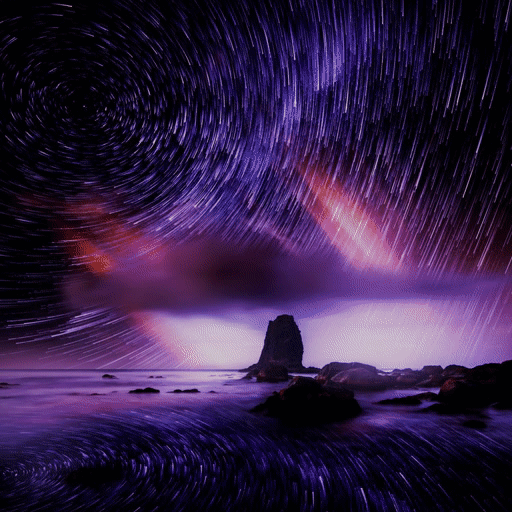

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tqdm.notebook import tqdm
print("Dependecies imported successfully.")
print("Version of OpenCV used = ", cv2.__version__)
print("Version Of Tensorflow used = ", tf.__version__)

In [ ]:
train = pd.DataFrame(pd.read_csv("../input/cassava-leaf-disease-classification/train.csv"))

train.head()

In [ ]:
train_image_statistics = pd.DataFrame(pd.read_csv("../input/cassavaimagestatistics/train_image_statistics.csv"))

train_image_statistics.head()

# Image Processing :

These ideas have been taken from my previous notebook : **https://www.kaggle.com/fireheart7/nosedive-eda-cum-image-processing**. 

I am directly using the functions here. If you wish to know behind the curtain details, then do have a look at that book.

In [ ]:
def non_local_means_denoising(image) : 
    denoised_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    return denoised_image

In [ ]:
def histogram_equalization(image) : 
    image_ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCR_CB)
    y_channel = image_ycrcb[:,:,0] # apply local histogram processing on this channel
    cr_channel = image_ycrcb[:,:,1]
    cb_channel = image_ycrcb[:,:,2]
    
    # Local histogram equalization
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize=(8,8))
    equalized = clahe.apply(y_channel)
    equalized_image = cv2.merge([equalized, cr_channel, cb_channel])
    equalized_image = cv2.cvtColor(equalized_image, cv2.COLOR_YCR_CB2RGB)
    return equalized_image

# Stratified Sampling

Stratified sampling refers to a type of sampling method . With stratified sampling, we divides the population into separate groups, called strata. Then, a simple random sample is drawn from each group.

So, to effectivey take a sample here, we will partition our training dataset into two : 

1. The actual training set.
2. The validation set.

Since the distribution of classes is not uniform, as we saw during EDA : **** , therefore **a stratified sampling ought to be preferred over simple random sampling of our data, for training and validation purposes**.

**An advantage of stratified sampling is that our validation set will be a mirror(but obviously unseen by our model) of our training dataset**. In a way, we make sure that every class is present in same proportion in our training and validation set.

For illustration of concept : 

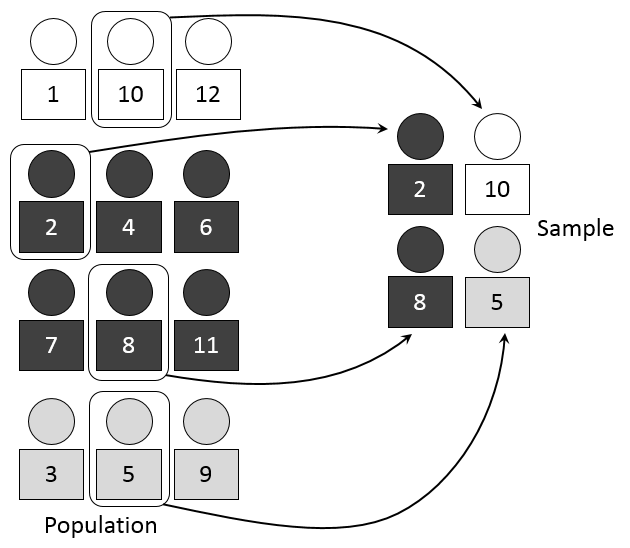

In [ ]:
SIZE = 2100 # these many images I am clipping in one .tfrec file.

num_of_images = len(os.listdir("../input/cassava-leaf-disease-classification/train_images"))
image_names = os.listdir("../input/cassava-leaf-disease-classification/train_images")

print("Number Of Training Images =",  num_of_images)

In [ ]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.15, random_state = 42)
for train_index, val_index in split.split(train, train["label"]) : 
    stratified_train_set = train.loc[train_index]
    stratified_val_set = train.loc[val_index]

Analysis of our stratified splitting.

In [ ]:
def analyze_label_distibution(dataframe) : # The training and validation dataframe created post stratified splitting are passed to this function.
    label_count = dict()
    for label in tqdm(dataframe["label"].values) : 
        if label not in label_count : 
            label_count[label] = 1
        else:
            label_count[label] += 1
    
    labels = ["Cassava Bacterial Blight (CBB)", "Cassava Brown Streak Disease (CBSD)", "Cassava Green Mottle (CGM)", 
          "Cassava Mosaic Disease (CMD)", "Healthy"]
    counts = [label_count[0], label_count[1], label_count[2], label_count[3], label_count[4]]

    explode = (0.05, 0.05, 0.05, 0.05, 0.05)
    #fig, ax = plt.subplots(figsize = (15, 12))
    plt.figure(figsize = (20, 12))
    plt.pie(counts, explode = explode, labels = labels, shadow = True, startangle = 90)
    plt.axis("equal")
    
    count_bacterial_blight = label_count[0]
    count_brown_streak = label_count[1]
    count_green_mottle = label_count[2]
    count_mosaic = label_count[3]
    count_healthy = label_count[4]

    print("Bacterial Blight count = ", count_bacterial_blight)
    print("Brown Steak Count = ", count_brown_streak)
    print("Green Mottle count = ", count_green_mottle)
    print("Mosaic count = ", count_mosaic)
    print("Healthy count = ", count_healthy)

In [ ]:
analyze_label_distibution(stratified_train_set)

In [ ]:
analyze_label_distibution(stratified_val_set)

As we can see, class distribution in training and validation sets are similar to each other. 

In [ ]:
training_image_ids = stratified_train_set["image_id"].values
validation_image_ids = stratified_val_set["image_id"].values

print("Number Of Training Images = ", len(training_image_ids))
print("Number of Validation Images = ", len(validation_image_ids))

# Defining Path To Images :

In [ ]:
PATH_TRAIN = "../input/cassava-leaf-disease-classification/train_images/"
PATH_VAL = "../input/cassava-leaf-disease-classification/train_images/"
PATH_TEST = "../input/cassava-leaf-disease-classification/test_images/"

# An Insight Into TFRecord File Format :

**It's Tensorflow's binary storage format for your data**.

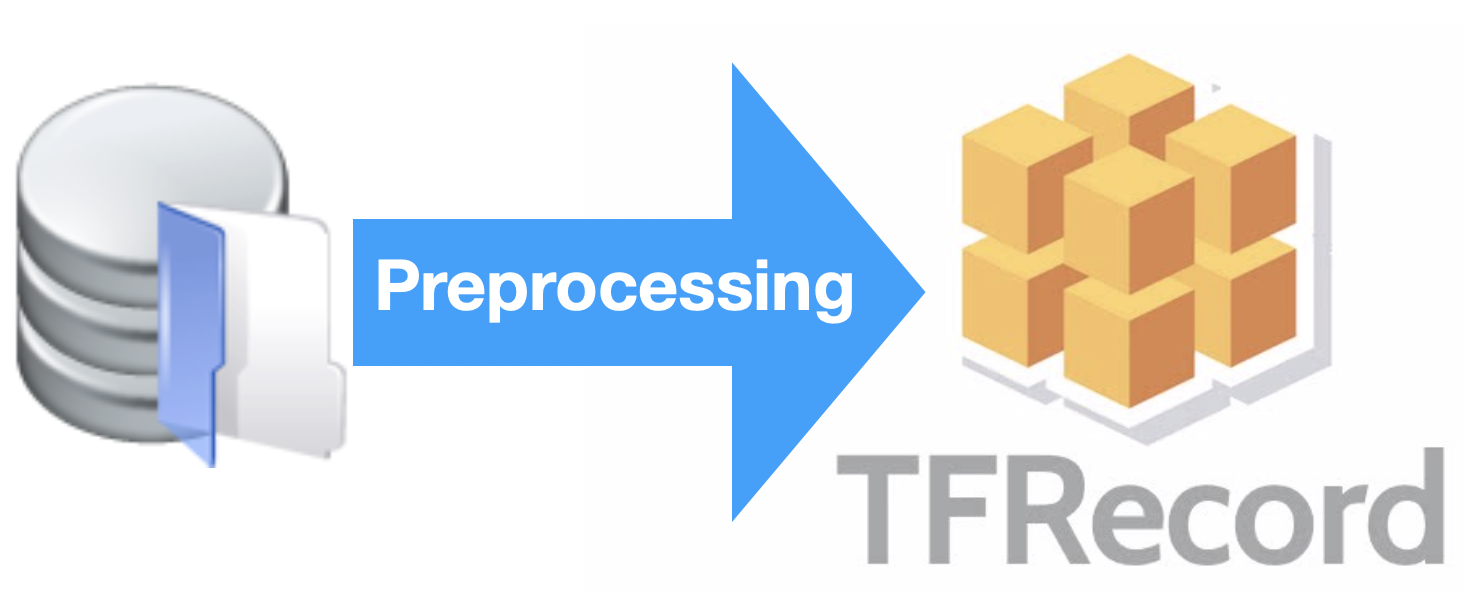

**************************************************************************************************************

Okay, so what's the endgame? Aren't JPEG, PNG also storage formats? What makes this one special ?

Being binary storage, data takes up relatively low space on your disk, and hence it takes less time to copy and can be read much more efficiently! Moreover, the tensorflow framework is optimized to handle tfrecords amazingly well.

The datasets that are too large to be stored fully in memory, **this is an advantage as only the data that is required at the time (e.g. a batch) is loaded from disk and then processed**.

Another major advantage of TFRecords is that **it is possible to store sequence data — for instance, a time series or word encodings — in a way that allows for very efficient and (from a coding perspective) convenient import of this type of data**.

******************************************************************************************************************

## TFRecord = Array of Examples :

A TFRecord file contains an array of Examples. 

**Example is a data structure for representing a record**, like an observation in a training or test dataset. 

**A record is represented as a set of features**, each of which has a name and can be an array of bytes, floats, or 64-bit integers.

For serialization using TFExample, we have to make any data fit into either one of 3 types:

* bytes_feature
* float_feature
* int_64_feature

In [ ]:
def bytes_features(value) : 
    """
    Returns a bytes_list from a string/byte. 
    
    isinstance() function : Returns True if the specified object is of the specified type, otherwise False. 
    Here, say in the first function tf.constant(0) is tensorflow.python.framework.ops.EagerTensor. 
    If passed value happens to be of this type, then True will be retured.
    """
    if isinstance(value, type(tf.constant(0))) : 
        value = value.numpy() # # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list = tf.train.BytesList(value = [value]))

def float_features(value) : 
    """
    Returns float_list from float/double.
    """
    return tf.train.Feature(float_list = tf.train.FloatList(value = [value]))

def int64_features(value) : 
    """
    Returns int64_list from a boolean/enum/int/uint.
    """
    return tf.train.Feature(int64_list = tf.train.Int64List(value = [value]))

All this heavy lifting was done in order to convert the features into Tensorflow compatible features. This is what we are gonna do now. We define a set of features and encapsulate them in an Example data structure.

Remember, to store or transfer an image, we often need to convert an image to a string in such a way that the string represents the image.

# Training TFRecords : 

In [ ]:
def serialize_example(feature_list) : 
    #feature_list = [image, image_name, label]
    feature = {
        "image" : bytes_features(feature_list[0]),
        "image_name" : bytes_features(feature_list[1]),
        "label" : int64_features(feature_list[2])
    }
    example_proto = tf.train.Example(features = tf.train.Features(feature = feature))
    return example_proto.SerializeToString()

In [ ]:
total_chunks = len(training_image_ids)//SIZE + int(len(training_image_ids) %SIZE != 0)

print("Total training TFRecord chunks to be prepared = ", total_chunks)

In [ ]:
for j in tqdm(range(total_chunks)) : 
    print("Writing TFRecord %i of %i"%(j, total_chunks))
    count = min(SIZE, len(training_image_ids) - (j * SIZE))
    with tf.io.TFRecordWriter("train%.2i-%i.tfrec"%(j, count)) as writer : 
        """
        This will be saved as train00-2071.tfrec (for illustration) where the numeral before hyphen is simply 
        a part of name whereas post hyphen denotes number of entries in this record. Here, 2071 entries are in
        the record. 
        """
        for k in range(count) : 
            image = cv2.imread(PATH_TRAIN + training_image_ids[(SIZE * j) + k])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # openCV reads images in BGR format
            image = cv2.resize(image, (256, 256), interpolation = cv2.INTER_NEAREST)
            #image = non_local_means_denoising(image)
            #image = histogram_equalization(image)
            """
            some more IP modules can be appended.
            
            """
            image = cv2.imencode(".jpg", image, (cv2.IMWRITE_JPEG_QUALITY, 95))[1].tostring()
            name_with_extension = training_image_ids[SIZE * j + k]
            name_without_extension = name_with_extension.split(".")[0]
            row = train.loc[train.image_id == name_with_extension]
            
            feature_list = [image, str.encode(name_without_extension), row.label.values[0]]
            
            example = serialize_example(feature_list)
            writer.write(example)
            
            if k%100 == 0 :
                print(k, ",", end = " ")

print("Training TFRecords Creation Successful! \n")

# Validation TFRecords

In [ ]:
total_chunks = len(validation_image_ids)//SIZE + int(len(validation_image_ids) %SIZE != 0)

print("Total training TFRecord chunks to be prepared = ", total_chunks)

In [ ]:
for j in tqdm(range(total_chunks)) : 
    print("Writing TFRecord %i of %i"%(j, total_chunks))
    count = min(SIZE, len(validation_image_ids) - (j * SIZE))
    with tf.io.TFRecordWriter("val%.2i-%i.tfrec"%(j, count)) as writer : 
        """
        This will be saved as val00-2071.tfrec (for illustration) where the numeral before hyphen is simply 
        a part of name whereas post hyphen denotes number of entries in this record. Here, 2071 entries are in
        the record. 
        """
        for k in range(count) : 
            image = cv2.imread(PATH_TRAIN + validation_image_ids[(SIZE * j) + k])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # openCV reads images in BGR format
            image = cv2.resize(image, (256, 256), interpolation = cv2.INTER_NEAREST)
            #image = non_local_means_denoising(image)
            #image = histogram_equalization(image)
            """
            some more IP modules can be appended.
            
            """
            image = cv2.imencode(".jpg", image, (cv2.IMWRITE_JPEG_QUALITY, 95))[1].tostring()
            name_with_extension = training_image_ids[SIZE * j + k]
            name_without_extension = name_with_extension.split(".")[0]
            row = train.loc[train.image_id == name_with_extension]
            
            feature_list = [image, str.encode(name_without_extension), row.label.values[0]]
            
            example = serialize_example(feature_list)
            writer.write(example)
            
            if k%100 == 0 :
                print(k, ",", end = " ")

print("Validation TFRecords Creation Successful! \n")

Similarily perform everything for testing set also.

# Testing TFRecords : 

In [ ]:
def serialize_example(feature_list) : 
    #feature_list = [image, image_name, label]
    feature = {
        "image" : bytes_features(feature_list[0]),
        "image_name" : bytes_features(feature_list[1])
    }
    example_proto = tf.train.Example(features = tf.train.Features(feature = feature))
    return example_proto.SerializeToString()

In [ ]:
SIZE = 1

num_of_images = len(os.listdir("../input/cassava-leaf-disease-classification/test_images"))
print("Number Of Testing Images =",  num_of_images)

In [ ]:
total_chunks = num_of_images//SIZE + int(num_of_images %SIZE != 0)

print("Total testing TFRecord chunks to be prepared = ", total_chunks)

In [ ]:
test_image_names = ["2216849948.jpg"]
for j in tqdm(range(total_chunks)) : 
    print("Writing TFRecord %i of %i"%(j, total_chunks))
    count = min(SIZE, num_of_images - (j * SIZE))
    with tf.io.TFRecordWriter("test%.2i-%i.tfrec"%(j, count)) as writer : 
        for k in range(count) : 
            image = cv2.imread(PATH_TEST + test_image_names[(SIZE * j) + k])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # openCV reads images in BGR format
            image = cv2.resize(image, (256, 256), interpolation = cv2.INTER_NEAREST)
            #image = non_local_means_denoising(image)
            #image = histogram_equalization(image)
            """
            some more IP modules can be appended.
            
            """
            image = cv2.imencode(".jpg", image, (cv2.IMWRITE_JPEG_QUALITY, 95))[1].tostring()
            name_with_extension = test_image_names[SIZE * j + k]
            name_without_extension = name_with_extension.split(".")[0]
            
            feature_list = [image, str.encode(name_without_extension)]
            
            example = serialize_example(feature_list)
            writer.write(example)
            
            if k%100 == 0 :
                print(k, ",", end = " ")
print("Test TFRecords Creation Successful! \n")

## Other Related Books : 

* **Nosedive-EDA cum Preprocessing** - EDA of Cassava Images. Link : **https://www.kaggle.com/fireheart7/nosedive-eda-cum-image-processing**
* **Cassava Metadata preparation** - Link : **https://www.kaggle.com/fireheart7/cassava-metadata-preparation**

## Thank You!